![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=1+-+BigQuery+Time+Series+Forecasting+Data+Review+and+Preparation.ipynb)

# 1 - Time Series Forecasting - Data Review in BigQuery

This series will explore forecasting with Vertex AI and BigQuery.  Forecasting is following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Before we look into methods of forecasting, this notebook will first look at a data source with a time element.  

This series will use bike Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will be complicated as new stations are introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at: `bigquery-public-data.new_york.citibike_trips`.

In this notebook we look at the data available and visualize the trend over time.

**Prerequisites:**
-  None

**Resources:**
- Blog: [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- Using BigQuery From Python, Notebooks in This Repository:
    - [Tips/BigQuery - Python Client](../Tips/BigQuery%20-%20Python%20Client.ipynb)
    - [01 - Data Sources/01 - BigQuery - Table Data Sources](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)
    - [03 - BigQuery ML (BQML)/03 - Introduction to BigQuery ML (BQML)](../03%20-%20BigQuery%20ML%20(BQML)/03%20-%20Introduction%20to%20BigQuery%20ML%20(BQML).ipynb)   

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore1_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore1_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-1'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE = 'bigquery-public-data.new_york.citibike_trips'
viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [4]:
bq = bigquery.Client()

---
## Data Setup

### Create BigQuery Dataset
Create a BigQuery Dataset within this project if missing:
- [Reference](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.dataset.Dataset.html#google.cloud.bigquery.dataset.Dataset)

In [5]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [6]:
ds.dataset_id

'applied_forecasting'

In [7]:
ds.full_dataset_id

'statmike-mlops-349915:applied_forecasting'

List BigQuery datasets in the project:

In [8]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
explained_columns
feature_engineering
forecasting_8_tournament
fraud
github_api
model_deployment_monitoring_1961322035766362112


### Review Source Data
Stored in BigQuery Public Datasets

Quick Preview:

In [9]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE}`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1257,2015-11-08 12:47:18+00:00,2015-11-08 13:08:16+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3102,Driggs Ave & Lorimer St,40.721791,-73.950415,14622,Subscriber,1983,male
1,1819,2016-03-12 15:07:43+00:00,2016-03-12 15:38:03+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,305,E 58 St & 3 Ave,40.760958,-73.967245,20955,Subscriber,1991,male
2,1024,2016-05-16 07:22:51+00:00,2016-05-16 07:39:55+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,282,Kent Ave & S 11 St,40.707645,-73.968415,22800,Subscriber,1970,male
3,2352,2016-06-06 17:58:29+00:00,2016-06-06 18:37:41+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,79,Franklin St & W Broadway,40.719116,-74.006667,25198,Subscriber,1964,male
4,1576,2015-10-18 16:12:03+00:00,2015-10-18 16:38:19+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,15006,Subscriber,1984,female


Parameters and common queries used for [cte](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#simple_cte).

If this notebook is being used as a starting point for a different data source then the cell below is a great place to customize the variables, time/date, filtering, and calculation of demand.

In [13]:
# CUSTOMIZE THIS CELL
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'

TIMESERIES = f"""
            SELECT
               CAST({SERIES_COLUMN} AS STRING) AS {SERIES_COLUMN},
               # One of the following two for the TIME_COLUMN
               EXTRACT(DATE from {TIME_COLUMN}) AS {TIME_COLUMN},
               # {TIME_COLUMN},
               COUNT(*) AS {TARGET_COLUMN}
            FROM `{BQ_SOURCE}`
            WHERE {SERIES_COLUMN} LIKE '%Central Park%'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
"""

ALLDATES = f"""
            SELECT
                # One of the following two for the TIME_COLUMN
                EXTRACT(DATE from {TIME_COLUMN}) AS {TIME_COLUMN},
                # {TIME_COLUMN},
            FROM `{BQ_SOURCE}`
            WHERE {SERIES_COLUMN} LIKE '%Central Park%'
"""

Quick Summary of Series with totals and date ranges for each series:

In [14]:
query = f"""
    WITH
        TIMESERIES AS (
            {TIMESERIES}
        )
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM TIMESERIES
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Visualize each series date/time range:

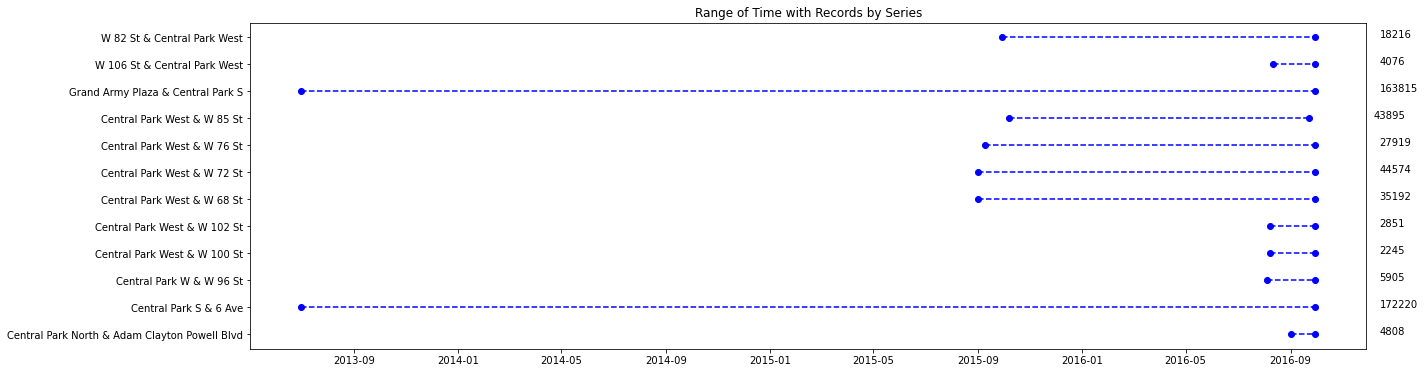

In [16]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [17]:
query = f"""
    WITH
        TIMESERIES AS (
            {TIMESERIES}
        )
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM TIMESERIES
"""
dates = bq.query(query).to_dataframe()

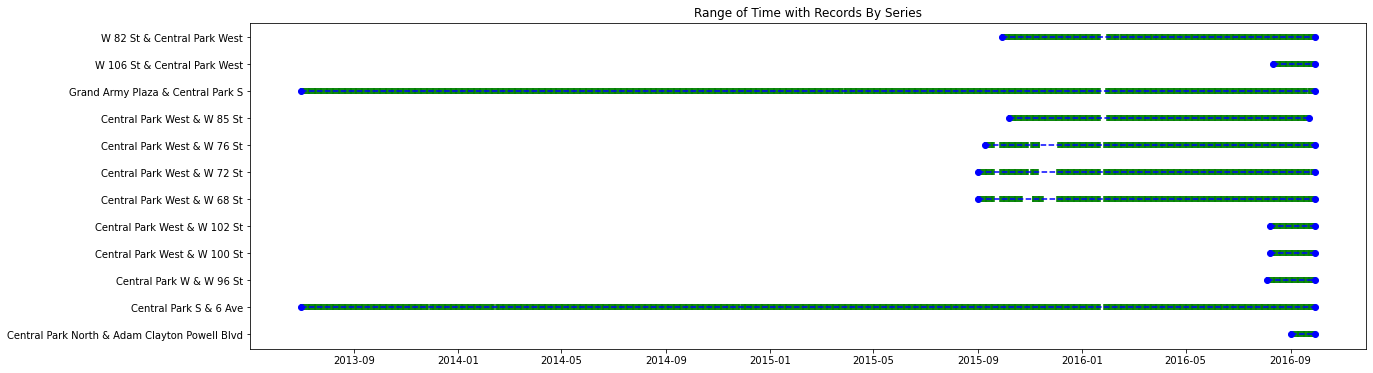

In [18]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

Get key dates from the series data while setting the forcast horizon:

In [19]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [20]:
query = f"""
    WITH
        ALLDATES AS(
            {ALLDATES}
        ),
        KEYS AS(
            SELECT 
                MIN({TIME_COLUMN}) as start_date,
                DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
                DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
                MAX({TIME_COLUMN}) as end_date
            FROM ALLDATES  
        )
    SELECT *
    FROM KEYS
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Visualize each series date/time range with proposed data segments from key dates:

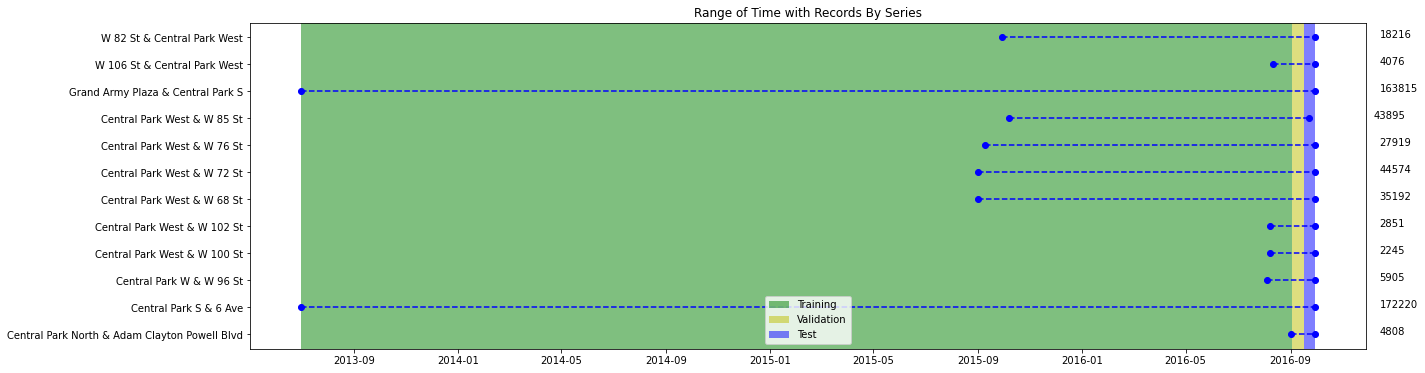

In [21]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create Source BigQuery Table for Forecasting
Put it all together!

In [22]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    WITH
        TIMESERIES AS (
            {TIMESERIES}
        )
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM TIMESERIES), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM TIMESERIES), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits
    FROM TIMESERIES
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

2.415

## Review Forecasting Data

In [23]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


Totals by data split:

In [24]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: int64

Overall total:

In [25]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4382

Visualize days of data available for forecasting at each series:

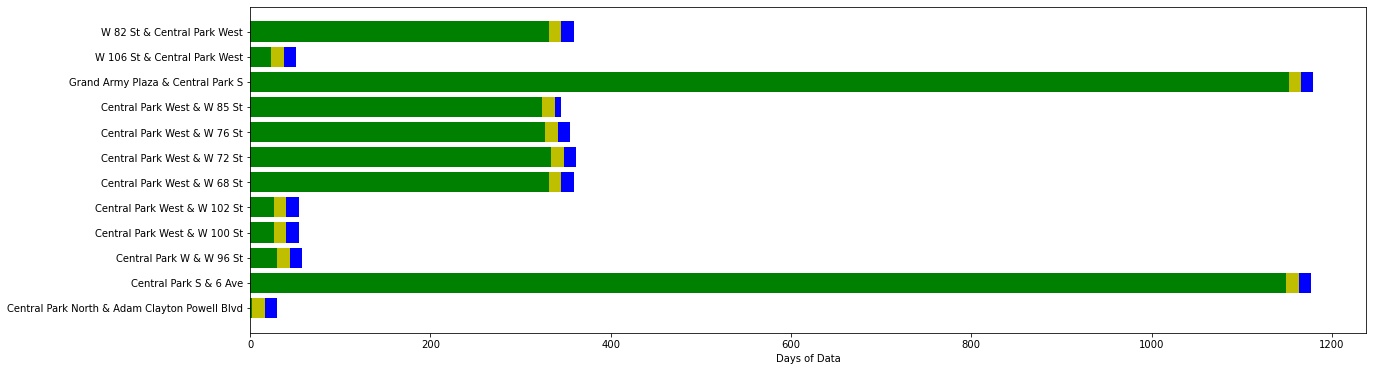

In [26]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [28]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


## Validation Check: Duplicate Dates in Series?
Are there any series with data for duplicate dates?

In [30]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq.query(query).to_dataframe()

,start_station_name,starttime,records


## Time Series Review

In [31]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, splits, sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}, splits
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

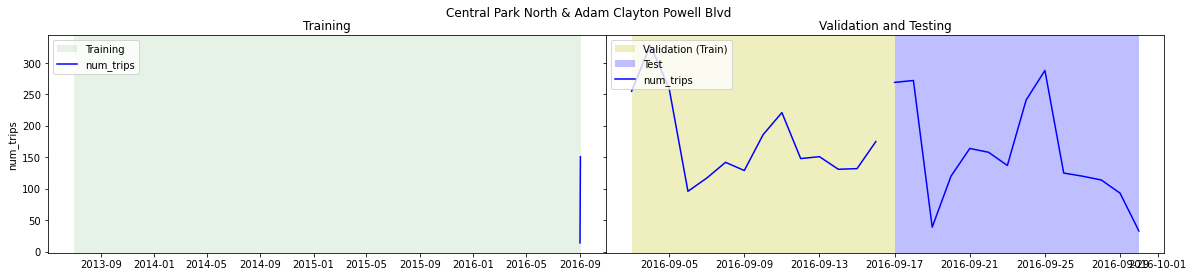

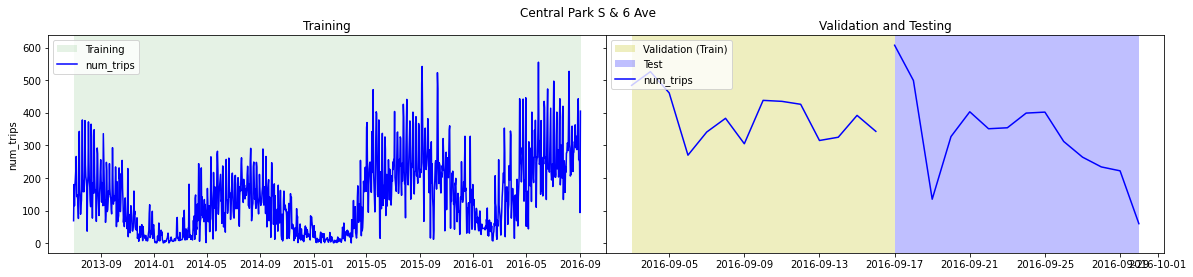

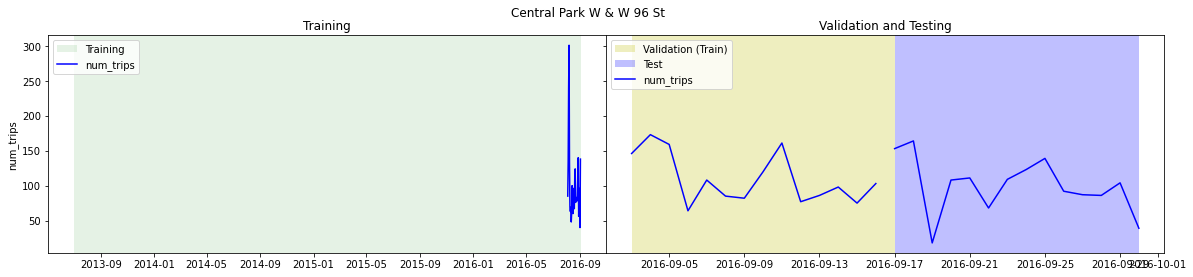

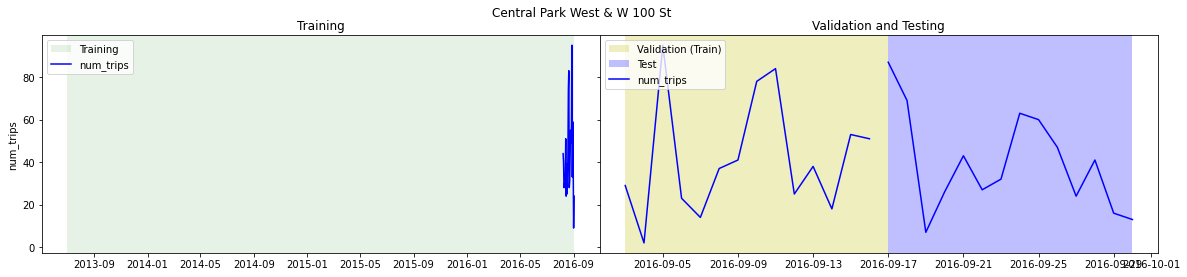

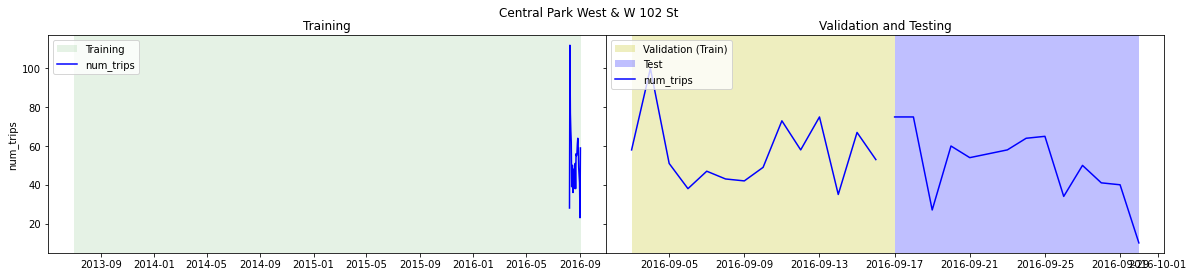

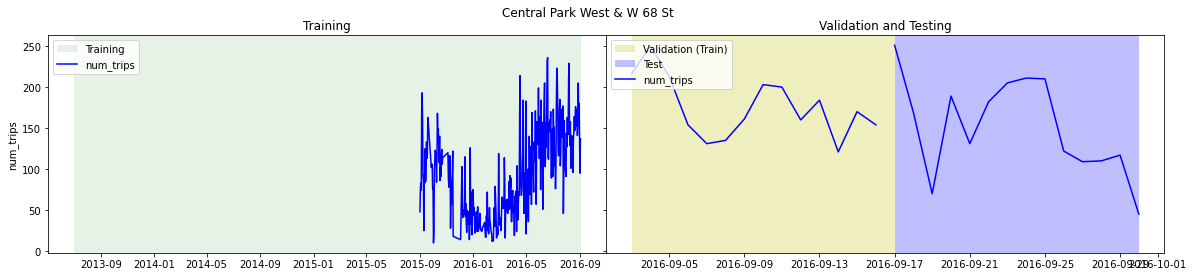

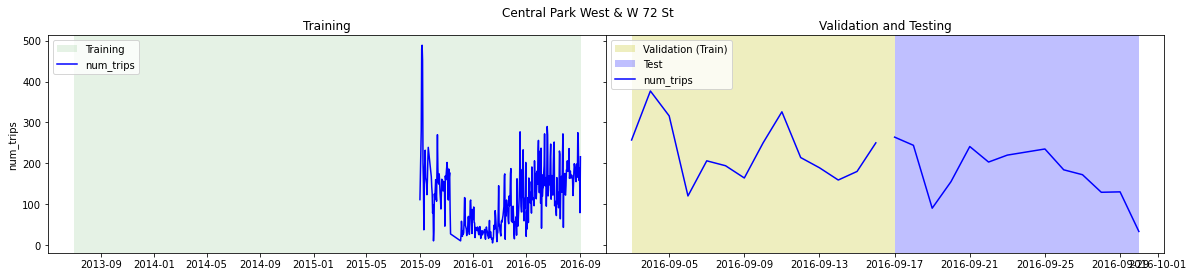

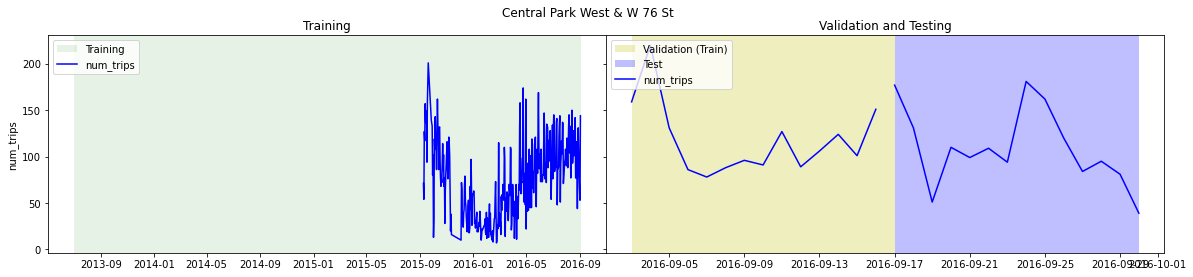

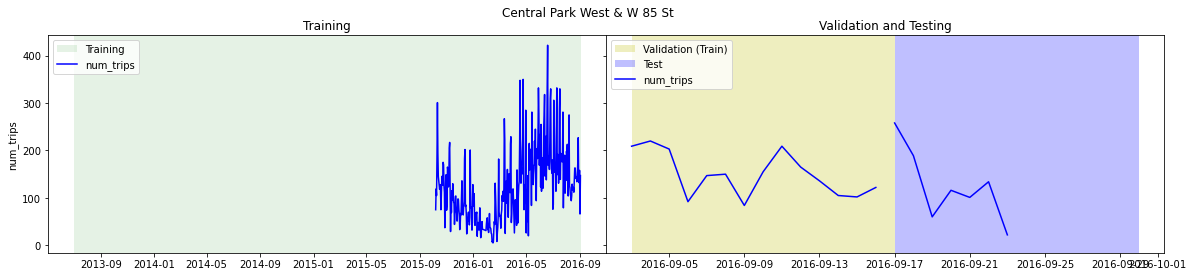

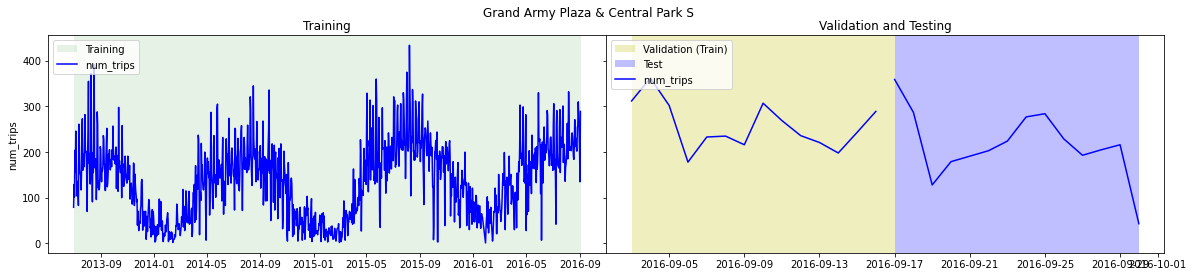

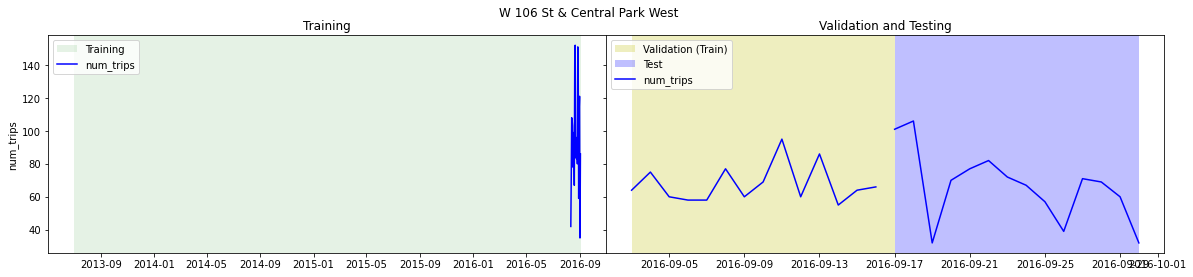

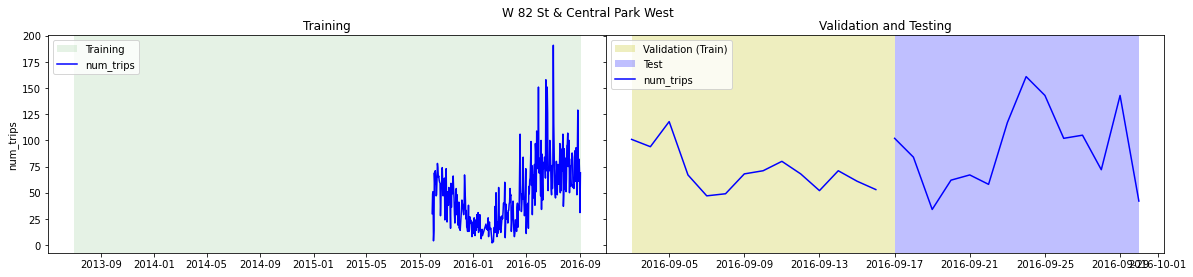

In [32]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"